In [ ]:
# Import libraries and standardize path
import os
from pathlib import Path
import numpy as np
import cv2
from tkinter.filedialog import askopenfilename
import SimpleITK as sitk
import nibabel as nib
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import zoom

In [4]:
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")
# Change directory as needed
os.chdir("/Users/Jacks/Desktop/Jackson's Homework/Year 4/BMEG 457/MRI-TO-PCT/Capstone Code and resources")

Current working directory: d:\Users\Jacks\Desktop\Jackson's Homework\Year 4\BMEG 457\MRI-TO-PCT\Capstone Code and resources\Code


In [ ]:
# Section for inverse log scaling + bias correction
image_path = "/Users/Jacks/Desktop/Jackson's Homework/Year 4/BMEG 457/MRI-TO-PCT/Capstone Code and resources/Images/chicken screenshot.png" # Change as needed

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Check the file path.")

# Convert to SimpleITK image format and cast to float
image_sitk = sitk.GetImageFromArray(image)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)

# Bias Field Correction (N4ITK)
corrector = sitk.N4BiasFieldCorrectionImageFilter()

# play around with hyperparameters--------------------------------------------------------
# Degree of the B-spline used for bias correction (smoothness)
corrector.SetSplineOrder(2)  # 2 looks the best
# Determines when the correction stops
corrector.SetConvergenceThreshold(10 ** -3)  # 10^-3 or smaller is best
# Impacts the histogram size for intensity mapping
corrector.SetNumberOfHistogramBins(50) # best is i = 50
# Controls the number of iterations at each resolution level
corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])  # best is standard -> i = 50
#-----------------------------------------------------------------------------------------

# Execute bias correction
corrected_image_sitk = corrector.Execute(image_sitk)

# Convert corrected image to NumPy array
corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)

# Normalize corrected image back to [0, 1] range
corrected_image = corrected_image / np.max(corrected_image)

# Scale to [0, 255] for saving as an image
corrected_image_uint8 = np.uint8(255 * corrected_image)

# Save corrected image

log_image = np.log(corrected_image + 1)  # Avoid log(0)
log_image = np.uint8(255 * log_image)
inverse_log_image = 255 - log_image  


inv_norm = inverse_log_image / 255.0

hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

#Change height to identify peaks 
peaks, _ = find_peaks(hist, height=7100)

# Threshold values
thresholds = bins[peaks]

plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Inverse Log-Scaled Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)

# ----------------

# image_sitk = sitk.GetImageFromArray(image)
# image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32) # Need to cast to float to avoid uint8 errors

# # Bias Field Correction (N4ITK)
# corrector = sitk.N4BiasFieldCorrectionImageFilter()
# corrected_image_sitk = corrector.Execute(image_sitk)

# corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)
# corrected_image = corrected_image / np.max(corrected_image) # Normalization from [0 - 1]

# log_image = np.log(corrected_image + 1) # Avoids log(0)
# log_image = np.uint8(255 * log_image)

# inverse_log_image = 255 - log_image  
# cv2.imwrite('/Users/yuhengzhang/Documents/BMEG 457/MRI-TO-PCT/Capstone Code and resources/Images/Yuheng_inverse_log_scaled_image.png', inverse_log_image)

True

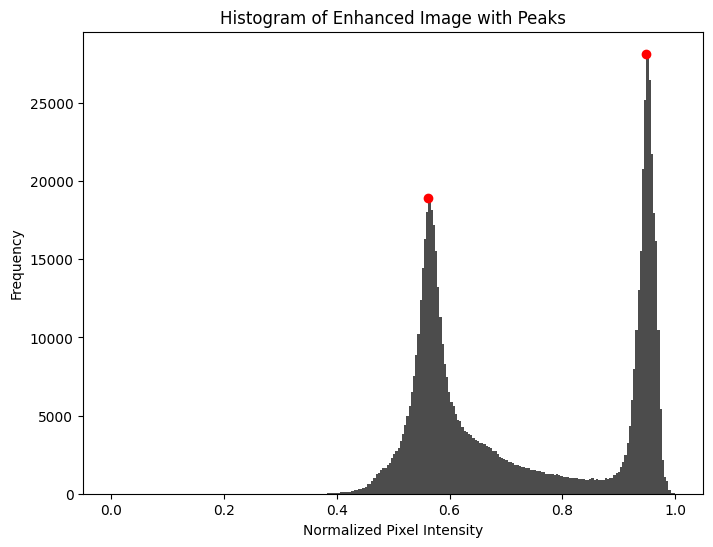

Thresholds for Peaks: [0.5625     0.94921875]


In [3]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from skimage import exposure

# Histogram Based bias correction applied to N4ITK approach

image_path = r"C:\Users\manan\Desktop\Capstone\MRI-TO-PCT\Capstone Code and resources\Images\chicken screenshot.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Check the file path.")

# Convert image to SimpleITK and float format
image_sitk = sitk.GetImageFromArray(image)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)

corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetSplineOrder(2)
corrector.SetConvergenceThreshold(1e-4)
corrector.SetNumberOfHistogramBins(100)
corrector.SetMaximumNumberOfIterations([100, 100, 100, 100])

corrected_image_sitk = corrector.Execute(image_sitk)
corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)

# Normalize corrected image to [0,1]
corrected_image = corrected_image / (np.max(corrected_image) + 1e-8)

log_image = np.log1p(corrected_image)  
inverse_log_image = 1.0 - log_image  
inverse_log_image /= np.max(inverse_log_image)  

def histogram_bias_correction(image, num_bins=256, min_counts=50, smoothing_sigma=5, levels=[1, 2, 4, 8]):
    corrected = np.copy(image).astype(np.float32)
    bias_field = np.ones_like(image, dtype=np.float32)

    for level in levels:
        downsampled_image = cv2.resize(corrected, (corrected.shape[1] // level, corrected.shape[0] // level), interpolation=cv2.INTER_LINEAR)

        hist, bin_edges = np.histogram(downsampled_image, bins=num_bins)
        max_count_idx = np.argmax(hist)  # Peak index
        if hist[max_count_idx] > min_counts:
            peak_intensity = bin_edges[max_count_idx]

            bias_field[:downsampled_image.shape[0], :downsampled_image.shape[1]] = peak_intensity

        # Apply Low-Pass Filtering 
        bias_field = gaussian_filter(bias_field, sigma=smoothing_sigma)

        
        corrected = corrected / (bias_field + 1e-8)  # Normalize
        corrected /= np.max(corrected)  # Scale to [0,1]

    return corrected

# Apply Histogram-Based Bias Correction 
final_corrected_image = histogram_bias_correction(inverse_log_image)

inv_norm = final_corrected_image  

# Compute histogram
hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

peak_threshold = max(1000, np.percentile(hist, 98))
peaks, _ = find_peaks(hist, height=peak_threshold)

thresholds = bins[peaks]

plt.figure(figsize=(8, 6))
plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Enhanced Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)


In [ ]:
# Section for Segmentation based on Previous Thresholds
segmented_image = inverse_log_image

# Manually choose thresholds based on above histogram bins and inverse log scaled image
threshold1 = 0.58 # or threshold[0] + 0.02, threshold[1], etc.
threshold2 = 0.86

# Segment the image based on thresholds (masking from literature)
# NOTE: Masks may need to be switched around based on the DICOM pictures (i.e if bone is darker and background is lighter)
soft_tissue_mask = (inv_norm < threshold1) 
bone_mask = (inv_norm >= threshold1) & (inv_norm < threshold2)  
air_mask = (inv_norm >= threshold2) 

# Assign greyscale values for segment display
segmented_image[air_mask] = 0  
segmented_image[soft_tissue_mask] = 100
segmented_image[bone_mask] = 255

# Save and display
cv2.imwrite('Images/CFP_segmented_image.png', segmented_image)
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Future Section for Registration
import matplotlib.pyplot as plt

next_image_path = 'Images/CFP_segmented_image.png' # Change as needed

reference_image = sitk.ReadImage('Images/CFP_segmented_image.png')  # Reference image (PCT)
next_image = sitk.ReadImage(next_image_path)

reference_image = sitk.Cast(reference_image, sitk.sitkFloat32)
next_image_path = sitk.Cast(next_image, sitk.sitkFloat32)

# Initialize B-Spline transform (Non-Rigid)
grid_size = [4, 4, 4]  # Number of control points per dimension
bspline_transform = sitk.BSplineTransformInitializer(reference_image, grid_size)

registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration.SetOptimizerAsGradientDescent(
    learningRate=1.0, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=10
)
registration.SetShrinkFactorsPerLevel([2, 1])
registration.SetSmoothingSigmasPerLevel([1, 0])
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Interpolator(for smooth deformations)
registration.SetInterpolator(sitk.sitkLinear)
registration.SetInitialTransform(bspline_transform, inPlace=True)

final_transform = registration.Execute(reference_image, next_image)

# Apply transformation
registered_image = sitk.Resample(next_image, reference_image, final_transform, sitk.sitkLinear, 0.0, next_image.GetPixelID())

sitk.WriteImage(registered_image, 'Images/TEST_REGISTERED_IMAGE.png')

In [ ]:
# Verification and Validation

